In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
from torchvision.datasets.utils import T
data_root = './data'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5),
    transforms.Lambda(lambda x : x.view(-1)),
])

train_set = datasets.MNIST(
     root = data_root,
     train = True,
     download = True,
     transform = transform
)

test_set = datasets.MNIST(
     root = data_root,
     train = False,
     download = True,
     transform = transform
)

100%|██████████| 9912422/9912422 [00:00<00:00, 118630476.30it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 9975763.31it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 35193764.14it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 16565677.19it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
image, label = train_set[0]
print('Image type:', type(image))
print('Image shape:', image.shape)

Image type: <class 'torch.Tensor'>
Image shape: torch.Size([784])


In [5]:
image, label = test_set[0]
print(len(test_set))
print('Image type:', type(image))
print('Image shape:', image.shape)

10000
Image type: <class 'torch.Tensor'>
Image shape: torch.Size([784])


In [6]:
print('min: ', image.data.min())
print('max: ', image.data.max())

min:  tensor(-1.)
max:  tensor(1.)


In [7]:
len(train_set)

60000

In [9]:
batch_size = 500

train_loader = DataLoader(
    train_set,
    batch_size = batch_size,
    shuffle = True
)

test_loader = DataLoader(
    test_set,
    batch_size = batch_size,
    shuffle = True
)

In [10]:
len(train_loader)

120

In [11]:
for image, label in train_loader:
    break
print(image.shape)
print(label.shape)

torch.Size([500, 784])
torch.Size([500])


In [12]:
n_input = 784
n_output = 10
n_hidden = 128

In [13]:
class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_hidden)
        self.l2 = nn.Linear(n_hidden, n_output)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

In [14]:
net = Net(n_input, n_output, n_hidden).to(device)

In [15]:
criterion = nn.CrossEntropyLoss()

In [16]:
lr = 0.01
optimizer = optim.SGD(net.parameters(), lr = lr)

In [17]:
history = np.zeros((0,5))
history

array([], shape=(0, 5), dtype=float64)

In [18]:
from tqdm.notebook import tqdm

In [ ]:
num_epoch = 100

for epoch in range(num_epoch):
    train_acc, train_loss = 0, 0
    val_acc, val_loss = 0, 0
    n_train, n_test = 0, 0

    for inputs, labels in tqdm(train_loader):
        n_train += len(labels)
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()
        predicted = torch.max(outputs, 1)[1]

        train_loss += loss.item()
        train_acc += (predicted == labels).sum().item()

    for inputs_test, labels_test in test_loader:
        n_test += len(labels_test)

        inputs_test = inputs_test.to(device)
        labels_test = labels_test.to(device)

        outputs_test = net(inputs_test)

        loss_test = criterion(outputs_test, labels_test)

        predicted_test = torch.max(outputs, 1)[1]

        val_loss += loss_test.item()
        val_acc += (predicted_test == labels_test).sum().item()

    train_acc = train_acc / n_train
    val_acc = val_acc / n_test
    train_loss = train_loss * batch_size / n_train
    val_loss = val_loss * batch_size / n_test

    print(f'Epoch [{epoch+1}/{num_epoch}],loss: {train_loss:5f} acc: {train_acc:5f} val_loss:{val_loss:5f}, val_acc: {val_acc: 5f}')
    items = np.array([epoch+1, train_loss, train_acc, val_loss, val_acc])
    history = np.vstack((history, items))

In [20]:
#損失と精度の確認
print(f'初期状態: 損失 {history[0,3]:5f} 精度: {history[0,4]:5f}')
print(f'最終状態: 損失 {history[-1,3]:5f} 精度: {history[-1,4]:5f}')

初期状態: 損失 1.330140 精度: 0.103200
最終状態: 損失 0.161721 精度: 0.101900


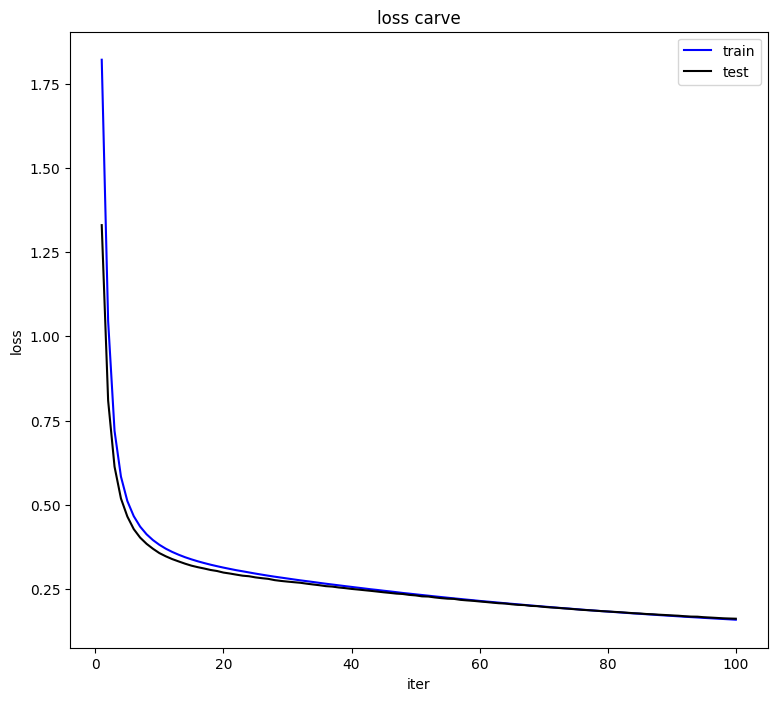

In [21]:
#学習曲線の表示（損失）
plt.rcParams['figure.figsize'] = (9,8)
plt.plot(history[:,0], history[:,1], 'b', label='train')
plt.plot(history[:,0], history[:,3], 'k', label='test')
plt.xlabel('iter')
plt.ylabel('loss')
plt.title('loss carve')
plt.legend()
plt.show()